In [23]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
from datetime import timedelta
import matplotlib.colors as colors
import matplotlib.ticker as tk

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
meshpath = ['/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/1_mesh_mask.nc']
# data_in = sorted(glob(datapath + 'test_2018_grid_[TUV].nc'))

# data_out = '/scratch/usr/shkifmmp/notebooks/shared-notebooks/master/'

datapath = '/scratch/usr/shkifmmp/master/data/ORION10/'
path_bathy = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT/'

In [17]:
def interpolate(year):
    YEAR = str(year)
    data_in = sorted(glob(datapath + 'chunked/' +'1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05_5d_' + YEAR + '0101_' + YEAR + '1231_grid_[TUV].nc'))

    # load data
    data = load_xorca_dataset(data_files=data_in, aux_files=meshpath, model_config='NEST',
               input_ds_chunks = {"time_counter": 73, "t": 73,
                                  "z": 11, "deptht": 11, "depthu": 11, "depthv": 11, "depthw": 11,
                                  "x": 100, "y": 100},
               target_ds_chunks = {"t": 73,
                                   "z_c": 11, "z_l": 11,
                                   "x_c": 100, "x_r": 100, "y_c": 100, "y_r": 100})

    # define metrics for xgcm (not strictly necessary)
    at, au = data['e1t'] * data['e2t'], data['e1u'] * data['e2u']
    av, af = data['e1v'] * data['e2v'], data['e1f'] * data['e2f']
    vt, vu, vv, vw = data['e3t'] * at, data['e3u'] * au, data['e3v'] * av, data['e3w'] * at

    data = data.update({'at': at, 'au': au, 'av': av, 'af': af, 'vt': vt, 'vu': vu, 'vv': vv, 'vw': vw})
    data = data.set_coords(['at', 'au', 'av', 'af', 'vt', 'vu', 'vv', 'vw'])

    metrics = {
        ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
        ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
        ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
        ('X', 'Y', 'Z'): ['vt', 'vu', 'vv', 'vw'] # Volumes
    }

    metrics2D = {
        ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
        ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
    }

    bathy = xr.open_dataset(path_bathy + '1_bathy_meter.nc')
    data = data.update({'bathymetry': (['y_c', 'x_c'], bathy['Bathymetry'].data)})

    grid = xgcm.Grid(data, metrics=metrics)

    # Calculate vorticity and Okubo-Weiss parameter and make sure the chunk sizes are as before.
#     data_OW = et.okuboweiss.calc(data.isel(z_c=9, z_l=9), grid,
#                                  'vozocrtx', 'vomecrty').chunk({'x_c': 1002, 'x_r': 1002,
#                                                                 'y_c': 629, 'y_r': 629})

    # Merge the new variables `OW` and `vort` to the dataset `data`
#     data = xr.merge([data, data_OW], compat='override')

    # INTERPOLATION
    # Define the parameters for the interpolation -- CONSIDER THE DISOCNTINUITY IN THE LONGITUDE
    interpolation_parameters = {'model': 'ORCA',
                                'grid': 'latlon',
                                'start_time': YEAR + '-01-01', # time range start
                                'end_time': YEAR + '-12-31', # time range end
                                'calendar': 'standard', # calendar, must be either 360_day or standard
                                'lon1': 77.5, # minimum longitude of detection region
                                'lon2': 69.5,  # maximum longitude
                                'lat1': -65, # minimum latitude
                                'lat2': -37, # maximum latitude
                                'res': 1./10., # resolution of the fields in degrees
                                'vars_to_interpolate': ['vozocrtx','vomecrty'],#['OW', 'vort'], # variables to be interpolated 
                                'mask_to_interpolate': ['fmask', 'tmask', 'bathymetry']} # masks to interpolate

    # The OW parameter and vorticity just need to be extracted at the depth level at which we want
    # to detect eddies. In this case we chose level 9
    data_int = et.interp.horizontal(data.isel(z_c=9, z_l=9), metrics2D, interpolation_parameters)

    # Now we change some of the parameters to interpolate other variables at all depths
    # Here we just use temperature and salinity
#     interpolation_parameters['vars_to_interpolate'] = ['votemper', 'vosaline']
#     interpolation_parameters['mask_to_interpolate'] = ['fmask', 'tmask']

    # Now we don't restrict the interpolation to one depth level
#     data_int = et.interp.horizontal(data, metrics, interpolation_parameters)

    # Load `OW` into memory so the `.rolling` operation is faster
#     OW_tmp = data_int_OW['OW'].compute()

     # Convert all land values to `NaN` so we don't have a lot of zeros when calculating
    # the standard deviation
#     OW_tmp = OW_tmp.where(OW_tmp != 0)
#     lon_tmp = OW_tmp['lon'].where(OW_tmp['lon'] > 0, other=OW_tmp['lon'] + 360.)
#     OW_tmp = OW_tmp.assign_coords({'lon': lon_tmp})

#     mean_OW_spatial_std = OW_tmp.rolling(
#                               lon=100, center=True, min_periods=1
#                               ).std(skipna=True).rolling(
#                               lat=100, center=True, min_periods=1
#                               ).std(skipna=True).mean('time')

    # Merge all interpolated datasets into on (override is necessary because some mask etc.
    # variables have been written to all datasets)
#     data_int = xr.merge([data_int, data_int_OW], 
#                        compat='override').chunk({'time': 1, 'lat': 100, 'lon': 100})

    # use if OW_std is 2D
#     data_int = data_int.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})

    data_int = data_int.chunk({'lon': 3561, 'lat': 501})
    with ProgressBar():
        data_int.to_netcdf(datapath + 'interpolated/' + 'int_data_74_t300_y' + YEAR + '_vel.nc')
        
    del data_int, data

In [ ]:
# interpolate(1974)

In [3]:
def open_eddies(region): #later update with model
    case = 9
    files_tmp = sorted(glob('/scratch/usr/shkifmmp/master/data/ORION10/eddies_detect/' + region + '/case' + str(case) + '/case' + str(case) + '_*_eddies_OW0.*.pickle'))
    eddies = {}
    factor=0.3
    for i in np.arange(0,len(files_tmp)):
        if region == 'region_4_old':
            datestring = files_tmp[i][81:91]
            lon1 = 77.5
            lon2 = 100
        else:
            datestring = files_tmp[i][82:92]
            lon1= -76
            lon2=-50
        with open(datapath + 'eddies_detect/' + region + '/case' + str(case) +'/case' + str(case) + '_'
                  + str(datestring) + '_eddies_OW' + str(factor) + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'rb') as f:
            eddies.update({i: pickle.load(f)})
    return eddies

In [4]:
def pre_detection(model): #adicionar year_start
    
    if model == 'ORION10':
#         data_int = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y200[6-9]*') + glob(datapath + 'interpolated/' + 'int_data_75*y2010*')))
        data_int = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y197[0-4]*')))

#     elif model == 'ORION10X':
#         data_int = xr.open_mfdataset(sorted(glob(datapath_X + 'interpolated/' + 'int_data_75*y200[6-9]*') + glob(datapath + 'interpolated/' + 'int_data_75*y2010*')))
        
    data_int['OW_std'] = data_int.OW_std.mean('time')
    data_int['bathymetry'] = data_int.bathymetry.mean('time')
    data_int['e1f'] = data_int.e1f.mean('time')
    data_int['e2f'] = data_int.e2f.mean('time')
    data_int['fmask'] = data_int.fmask.mean('time')
    data_int['tmask'] = data_int.tmask.mean('time')
    
    mask_tmp = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y2000*'))).mask_regions
    
    mask = mask_tmp.copy()
    mask = mask.where(mask == 0, other=1)
    OW_test = data_int.OW * mask
    OW_std_test = data_int.OW_std * mask
    vort_test = data_int.vort * mask

# data_int = data_int.update({'mask_regions_2': mask})
    data_int = data_int.update({'OW_test': OW_test,
                               'OW_std_test': OW_std_test,
                               'vort_test': vort_test})
    return data_int

In [5]:
mask_tmp = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y2000*'))).mask_regions
    
mask = mask_tmp.copy()
mask = mask.where(mask == 0, other=1)

### OW fields

In [6]:
data_int = pre_detection('ORION10')

In [ ]:
data_int

In [71]:
eddies = open_eddies('drake_passage')

In [73]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': -76, # minimum longitude of detection region
                        'lon2': -50, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
#                         'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 421} # maximum number of pixels (grid cells)

/scratch/tmp/shkifmmp/ipykernel_407256/2200189788.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])


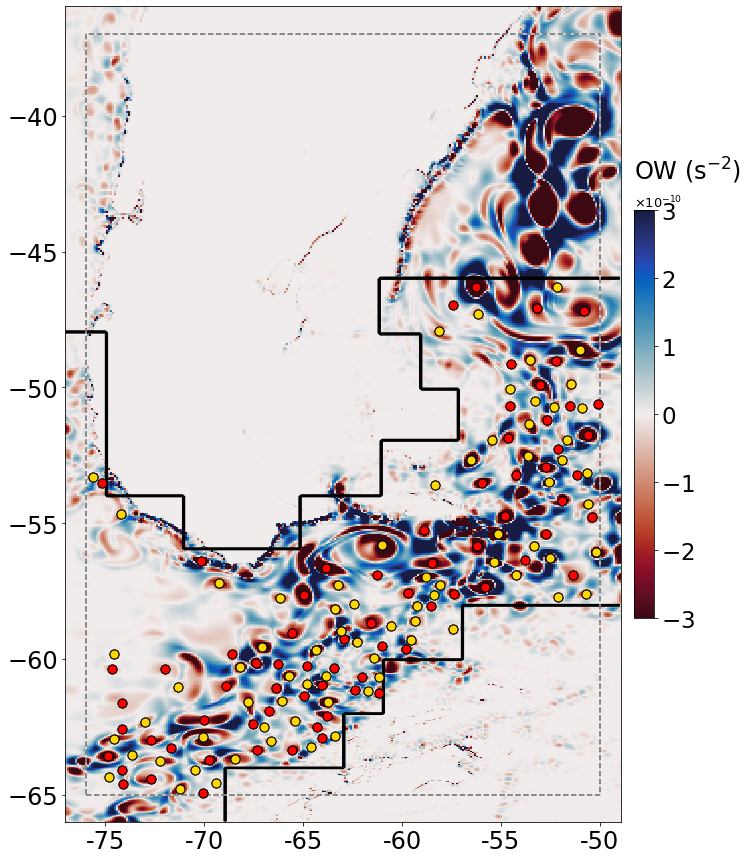

In [60]:
# Plot a single time step to see what the detection method detected
t=300
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values)# + 360)

plt.figure(figsize=(12,15))

map1 = plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-77,-49)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
#                vmin=-3e-10, vmax=0, 
               cmap=cm.balance_r, shading='auto')

plt.contour(plot_lon, data_int['lat'].values, mask.sel(lon = slice(-77,-49)), colors= 'black')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] #+ 360
    else:
        eddy_lon = eddies[t][i]['lon']
    if eddies[t][i]['type'] == 'anticyclonic':
        for s, c in zip([7, 6], ['k', 'red']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=9, markeredgecolor='k')
    if eddies[t][i]['type'] == 'cyclonic':
        for s, c in zip([7, 6], ['k', 'gold']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=9, markeredgecolor='k')
#     for s, c in zip([7, 6], ['k', 'gold']):
#         plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

fmt = tk.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

c = plt.colorbar(map1, pad=0.02, shrink=0.5, format=fmt)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=24, y=1.06)

c.ax.yaxis.set_offset_position('left')
# c.ax.text(-0.25, 1, r'$\times$10$^{-10}$', va='bottom', ha='left',transform=ax.transAxes)
# c.ax.yaxis.get_offset_text('left')
c.ax.yaxis.get_offset_text().set_fontsize(13)
c.ax.tick_params(labelsize=23)

ax = plt.gca()

# ax.set_title('a)', loc='left', fontsize=20)
ax.xaxis.set_tick_params(labelsize = 24)
ax.yaxis.set_tick_params(labelsize = 24)
ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_drake_t{}_case9_thesis_difftypes.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [41]:
c.ax.yaxis.get_offset_text().

Signature: c.ax.yaxis.get_offset_text()
Docstring: Return the axis offsetText as a Text instance.
File:      ~/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/matplotlib/axis.py
Type:      method


In [ ]:
c.ax.yaxis.get_offset_text().set_fontsize(18).set_position

In [ ]:
c.ax.yaxis.get_offset_text().set_fontsize(18).set_location

In [58]:
c.ax.xaxis.set_offset_position?

Object `c.ax.xaxis.set_offset_position` not found.


In [12]:
c.ax.yaxis.get_offset_text?


Signature: c.ax.yaxis.get_offset_text()
Docstring: Return the axis offsetText as a Text instance.
File:      ~/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/matplotlib/axis.py
Type:      method


### Calculating absolute velocities

In [62]:
# For analysis of more years
data_int_V = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data*y197[0-4]*_vel*')))

In [63]:
vel_x = data_int_V.vozocrtx

vel_y = data_int_V.vomecrty

In [16]:
1e0

1.0

### t=200 (1972-09-30), t=300 (1974-02-12), t=30 (1970-06-02)

In [64]:
tot_vel_300 = np.abs(np.sqrt(vel_x.sel(time='1974-02-12')**2 + vel_y.sel(time='1974-02-12')**2)).squeeze()

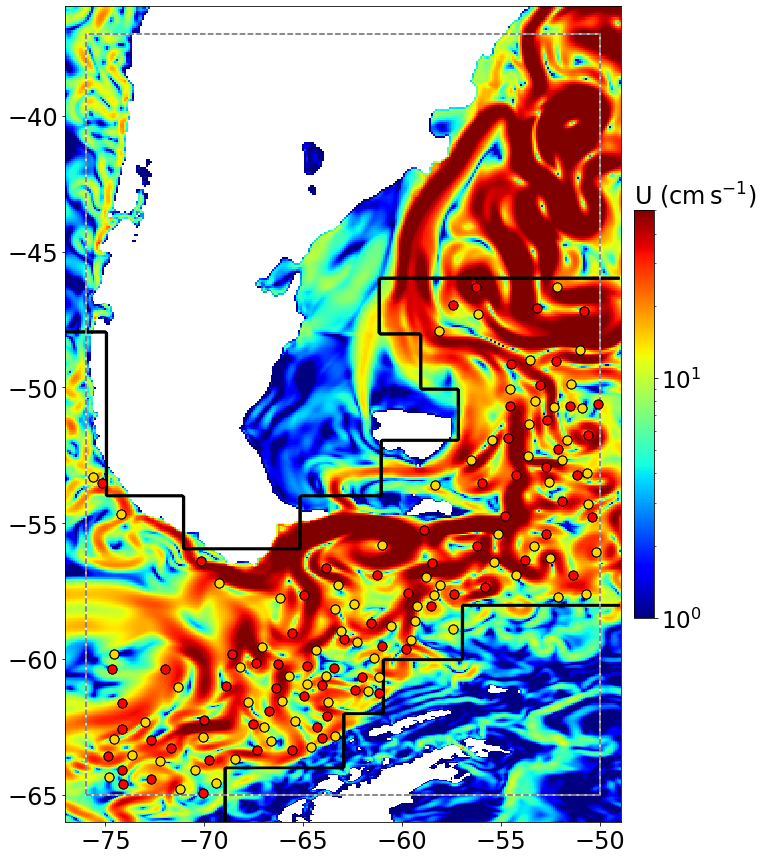

In [74]:
# Plot a single time step to see what the detection method detected
t=300
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values)# + 360)

plt.figure(figsize=(12,15))
map1=plt.pcolormesh(plot_lon, data_int['lat'].values, 1e2*(tot_vel_300.sel(lon = slice(-77,-49)).values),
               norm = colors.LogNorm(vmin=1e0, vmax=50), 
               cmap= 'jet', shading='auto')

plt.contour(plot_lon, data_int['lat'].values, mask.sel(lon = slice(-77,-49)), colors= 'black')


for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] #+ 360
    else:
        eddy_lon = eddies[t][i]['lon']
    if eddies[t][i]['type'] == 'anticyclonic':
        for s, c in zip([7, 6], ['k', 'red']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=9, markeredgecolor='k')
    if eddies[t][i]['type'] == 'cyclonic':
        for s, c in zip([7, 6], ['k', 'gold']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=9, markeredgecolor='k')
    
# for i in np.arange(0, len(eddies[t])-1):
#     if eddies[t][i]['lon'] < 0:
#         eddy_lon = eddies[t][i]['lon'] #+ 360
#     else:
#         eddy_lon = eddies[t][i]['lon']
#     for s, c in zip([7, 6], ['k', 'gold']):
#         plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(map1,pad=0.02, shrink=0.5)
c.ax.set_title('U (cm$\,$s$^{-1}$)', loc='left', fontsize=24)#, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=23)

ax = plt.gca()

# ax.set_title('b)', loc='left', fontsize=20)
ax.xaxis.set_tick_params(labelsize = 24)
ax.yaxis.set_tick_params(labelsize = 24)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_drake_t{}_case9_vel_thesis_difftypes.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [37]:
plt.title?

Signature: plt.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)
Docstring:
Set a title for the Axes.

Set one of the three available Axes titles. The available titles
are positioned above the Axes in the center, flush with the left
edge, and flush with the right edge.

Parameters
----------
label : str
    Text to use for the title

fontdict : dict
    A dictionary controlling the appearance of the title text,
    the default *fontdict* is::

       {'fontsize': rcParams['axes.titlesize'],
        'fontweight': rcParams['axes.titleweight'],
        'color': rcParams['axes.titlecolor'],
        'verticalalignment': 'baseline',
        'horizontalalignment': loc}

loc : {'center', 'left', 'right'}, default: :rc:`axes.titlelocation`
    Which title to set.

y : float, default: :rc:`axes.titley`
    Vertical Axes loation for the title (1.0 is the top).  If
    None (the default), y is determined automatically to avoid
    decorators on the Axes.

pad : float, default: :

## REGION 4

In [75]:
eddies = open_eddies('region_4_old')

In [76]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 100, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.5, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 213} # maximum number of pixels (grid cells)

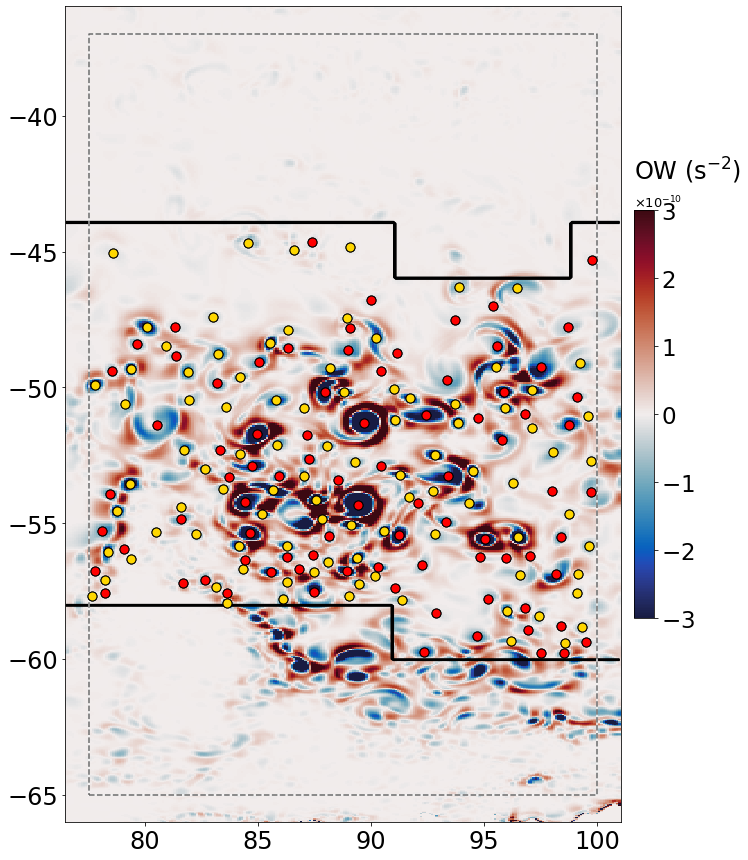

In [80]:
# Plot a single time step to see what the detection method detected
t=300
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
map1 = plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,101)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

plt.contour(plot_lon, data_int['lat'].values, mask.sel(lon = slice(76.5,101)), colors= 'black')

    
for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] #+ 360
    else:
        eddy_lon = eddies[t][i]['lon']
    if eddies[t][i]['type'] == 'anticyclonic':
        for s, c in zip([7, 6], ['k', 'red']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=9, markeredgecolor='k')
    if eddies[t][i]['type'] == 'cyclonic':
        for s, c in zip([7, 6], ['k', 'gold']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=9, markeredgecolor='k')
    
# for i in np.arange(0, len(eddies[t])-1):
#     if eddies[t][i]['lon'] < 0:
#         eddy_lon = eddies[t][i]['lon'] + 360
#     else:
#         eddy_lon = eddies[t][i]['lon']
#     for s, c in zip([7, 6], ['k', 'gold']):
#         plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

fmt = tk.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

c = plt.colorbar(map1, pad=0.02, shrink=0.5, format=fmt)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=24, y=1.06)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(13)
c.ax.tick_params(labelsize=23)

ax = plt.gca()

# ax.set_title('c)', loc='left', fontsize=20)
ax.xaxis.set_tick_params(labelsize = 24)
ax.yaxis.set_tick_params(labelsize = 24)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_REGION4_t{}_case9_difftypes.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

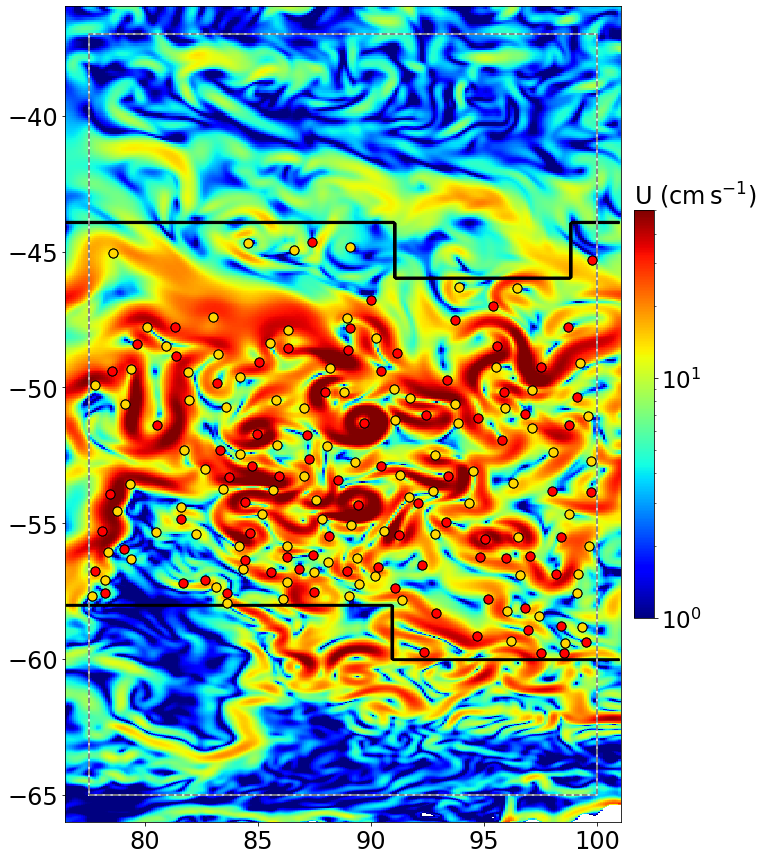

In [82]:
# Plot a single time step to see what the detection method detected
t=300
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
map1 = plt.pcolormesh(plot_lon, data_int['lat'].values, 1e2*(tot_vel_300.sel(lon = slice(76.5,101)).values),
               norm = colors.LogNorm(vmin=1e0, vmax=50), 
               cmap='jet', shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

plt.contour(plot_lon, data_int['lat'].values, mask.sel(lon = slice(76.5,101)), colors= 'black')

    
for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] #+ 360
    else:
        eddy_lon = eddies[t][i]['lon']
    if eddies[t][i]['type'] == 'anticyclonic':
        for s, c in zip([7, 6], ['k', 'red']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=9, markeredgecolor='k')
    if eddies[t][i]['type'] == 'cyclonic':
        for s, c in zip([7, 6], ['k', 'gold']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=9, markeredgecolor='k')
    
# for i in np.arange(0, len(eddies[t])-1):
#     if eddies[t][i]['lon'] < 0:
#         eddy_lon = eddies[t][i]['lon'] + 360
#     else:
#         eddy_lon = eddies[t][i]['lon']
#     for s, c in zip([7, 6], ['k', 'gold']):
#         plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(map1,pad=0.02, shrink=0.5)
c.ax.set_title('U (cm$\,$s$^{-1}$)', loc='left', fontsize=24)#, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(13)
c.ax.tick_params(labelsize=23)

ax = plt.gca()

# ax.set_titl('d)', loc='left', fontsize=20)
ax.xaxis.set_tick_params(labelsize = 24)
ax.yaxis.set_tick_params(labelsize = 24)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_REGION4_t{}_vel_case9_difftypes.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')